# Evaluation

## Import Libraries

In [1]:
from pathlib import Path

import torch
import psutil
import numpy as np
import pandas as pd
import seaborn as sns
import shap
import matplotlib.pyplot as plt
import torch.nn.functional as F
from petastorm import make_reader
from petastorm.pytorch import DataLoader
from sklearn import metrics

from ml.vae import VAE

## Configuration

In [2]:
model_path = '/home/munhou/gee/model/vae.model'
data_path = '/home/munhou/gee/model_input/test.model_input.parquet'

# get number of cores
num_cores = psutil.cpu_count(logical=True)

## Load Model

In [3]:
model = VAE.load_from_checkpoint(checkpoint_path=model_path, map_location=torch.device('cuda'))

model.eval()

VAE(
  (encoder): Encoder(
    (fc): Sequential(
      (0): Linear(in_features=69, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=1024, bias=True)
      (5): ReLU()
    )
    (mu): Linear(in_features=1024, out_features=100, bias=True)
    (logvar): Linear(in_features=1024, out_features=100, bias=True)
  )
  (decoder): Decoder(
    (fc): Sequential(
      (0): Linear(in_features=100, out_features=1024, bias=True)
      (1): ReLU()
      (2): Linear(in_features=1024, out_features=512, bias=True)
      (3): ReLU()
      (4): Linear(in_features=512, out_features=512, bias=True)
      (5): ReLU()
      (6): Linear(in_features=512, out_features=69, bias=True)
      (7): Sigmoid()
    )
  )
)

## Construct Data Loader

In [4]:
reader = make_reader(
    Path(data_path).absolute().as_uri(), reader_pool_type='process', workers_count=num_cores,
    pyarrow_serialize=True, num_epochs=1
)
dataloader = DataLoader(reader, batch_size=300, shuffling_queue_capacity=4096)

## Define Reconstruct Error Function

In [5]:
def calc_recon_loss(recon_x, x, logvar = None, mu = None, loss_type: str = 'mse') -> list:
    """
    Return the reconstruction loss

    :param recon_x: reconstructed x, output from model
    :param x: original x
    :param logvar: variance, output from model, ignored when loss_type isn't 'bce+kd'
    :param mu: mean, output from model, ignored when loss_type isn't 'bce+kd'
    :param loss_type: method to compute loss, option: 'bce', 'mse', 'bce+kd'
    :return: list of reconstruct errors
    :rtype: list
    """

    loss_type = loss_type.lower()

    # 69 is the number of features
    if loss_type == 'mse':
        recon_error = F.mse_loss(recon_x, x, reduction='none').view(-1, 69).mean(dim=1)
    elif loss_type == 'bce':
        recon_error = F.binary_cross_entropy(recon_x, x, reduction='none').view(-1, 69).mean(dim=1)
    elif loss_type == 'bce+kd':
        bce = F.binary_cross_entropy(recon_x, x, reduction='none').view(-1, 69).mean(dim=1)
        kd = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        recon_error = bce + kd
    else:
        raise Exception('Invalid loss type: only support "mse", "bce", or "bce+kd"')

    return recon_error.tolist()

## Plot Function

### Plot for ROC

In [6]:
def plot_roc(df: pd.DataFrame, malicious_type: str):
    malicious_type_set = {'anomaly-spam', 'blacklist', 'dos', 'nerisbotnet', 'scan11', 'scan44'}

    if malicious_type not in malicious_type_set:
        raise Exception(f'Invalid malicious_type, only support "{malicious_type_set}"')

    part_df = df[(df['label'] == 'background') | (df['label'] == malicious_type)]
    label = (
        part_df
            .label.replace({
                'background': 0,
                malicious_type: 1,
            })
        .tolist()
    )


    mse_loss = part_df.mse_loss.tolist()
    bce_loss = part_df.bce_loss.tolist()
    bce_kd_loss = part_df['bce+kd_loss'].tolist()

    fig, ax = plt.subplots(figsize=(5, 5))

    fpr_mse, tpr_mse, thresholds_mse = metrics.roc_curve(label, mse_loss)
    fpr_bce, tpr_bce, thresholds_bce = metrics.roc_curve(label, bce_loss)
    fpr_bce_kd, tpr_bce_kd, thresholds_bce_kd = metrics.roc_curve(label, bce_kd_loss)

    auc_mse = metrics.auc(fpr_mse, tpr_mse)
    auc_bce = metrics.auc(fpr_bce, tpr_bce)
    auc_bce_kd = metrics.auc(fpr_bce_kd, tpr_bce_kd)

    ax.plot([0, 1], [0,1], 'k--')
    ax.plot(fpr_mse, tpr_mse, label=f'with mse loss (auc = {auc_mse: .2f})')
    ax.plot(fpr_bce, tpr_bce, label=f'with bce loss (auc = {auc_bce: .2f})')
    ax.plot(fpr_bce_kd, tpr_bce_kd, label=f'with bce+kd loss (auc = {auc_bce_kd: .2f})')

    ax.set_xlabel('False positive rate')
    ax.set_ylabel('True positive rate')

    ax.set_title(f'ROC of background and {malicious_type}')

    ax.legend(loc='lower right')

    fig.show()

### Plot for KDE

In [7]:
def plot_kde(df: pd.DataFrame, loss_type: str, malicious_type: str):
    loss_type_set = {'mse', 'bce', 'bce+kd'}
    if loss_type not in loss_type_set:
        raise Exception(f'Invalid loss_type, only support "{loss_type}"')

    malicious_type_set = {'anomaly-spam', 'blacklist', 'dos', 'nerisbotnet', 'scan11', 'scan44'}
    if malicious_type not in malicious_type_set:
        raise Exception(f'Invalid malicious_type, only support "{malicious_type_set}"')

    normal_recon_error = df[df['label'] == 'background'][f'{loss_type}_loss'].tolist()
    malicious_recon_error = df[df['label'] == malicious_type][f'{loss_type}_loss'].tolist()

    fig, ax = plt.subplots(figsize=(5, 5))
    sns.kdeplot(
        normal_recon_error,
        ax=ax,
        label=f'background {loss_type} loss'
    )
    sns.kdeplot(
        malicious_recon_error,
        ax=ax,
        label=f'{malicious_type} {loss_type} loss'
    )

    ax.set_title(f'Reconstruction Error Distribution of background traffic and {malicious_type}')
    ax.legend(loc='lower right')

    fig.show()

### Plot for Gradient

In [8]:
def plot_gradient(df: pd.DataFrame, malicious_type: str, model: VAE):
    malicious_type_set = {'anomaly-spam', 'blacklist', 'dos', 'nerisbotnet', 'scan11', 'scan44'}

    if malicious_type not in malicious_type_set:
        raise Exception(f'Invalid malicious_type, only support "{malicious_type_set}"')

    x = torch.FloatTensor(df[df['label'] == malicious_type]['x'].tolist())

    # clear gradient
    model.zero_grad()

    # get model output
    recon_x, logvar, mu = model(x)

    # calculate loss
    loss = model.loss_function(recon_x, x, mu, logvar)

    # get the gradient w.r.t loss
    grad = torch.autograd.grad(loss, recon_x, retain_graph=False)[0].view(-1, 69)

    # get selected feature grad only
    grad = grad[:, [11, 13, 46, 53, 0, 1, 6, 3, 2, 4, 9, 14, 30, 57, 42, 43]]

    # build selected feature name
    feature_name = [
        'entropy_dst_ip', 'entropy_dst_port', 'dst_SMTP', 'dst_HTTP', 'mean_duration', 'mean_packet', 'std_packet',
        'mean_packet_rate', 'mean_num_of_bytes', 'mean_byte_rate', 'std_byte_rate', 'entropy_flags', 'src_RPC',
        'dst_RPC', 'dst_FTP_20', 'dst_FTP_21'
    ]

    fig, ax = plt.subplots(figsize=(10, 10))

    sns.barplot(x=grad.T.reshape(-1).tolist(), y=feature_name * grad.shape[0], orient='h', ax=ax)

    ax.set_title(f'Gradient of {malicious_type}')

    fig.show()

## Calculate Reconstruction Error

In [9]:
x_list = []
label_list = []
mse_loss_list = []
bce_loss_list = []
bce_kd_loss_list = []

for data in dataloader:
    x = data['feature']
    label = data['label']
    recon_x, mu, logvar = model(x)

    mse_loss = calc_recon_loss(recon_x, x, loss_type='mse')
    bce_loss = calc_recon_loss(recon_x, x, loss_type='bce')
    bce_kd_loss = calc_recon_loss(recon_x, x, logvar, mu, loss_type='bce+kd')

    label_list.extend(label)
    mse_loss_list.extend(mse_loss)
    bce_loss_list.extend(bce_loss)
    bce_kd_loss_list.extend(bce_kd_loss)
    x_list.extend(x.tolist())

The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


## Construct a Pandas Dataframe for Easier Evaluation

In [10]:
df = pd.DataFrame(
    {
        'x': x_list,
        'mse_loss': mse_loss_list,
        'bce_loss': bce_loss_list,
        'bce+kd_loss': bce_kd_loss_list,
        'label': label_list
    }
)

## Plot ROC with Different Loss

### anomaly-spam

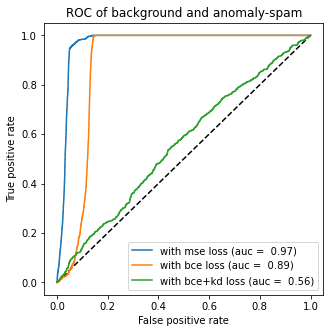

In [11]:
plot_roc(df, 'anomaly-spam')

### blacklist

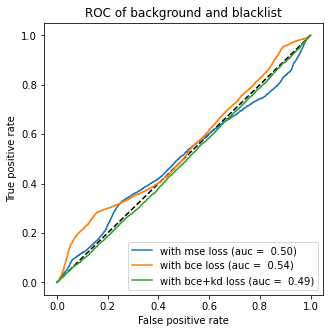

In [12]:
plot_roc(df, 'blacklist')

### dos

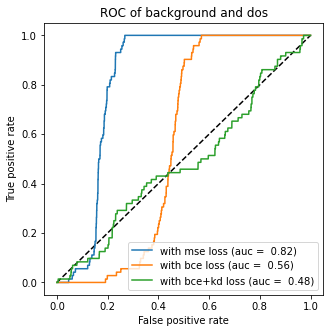

In [13]:
plot_roc(df, 'dos')

### nerisbotnet

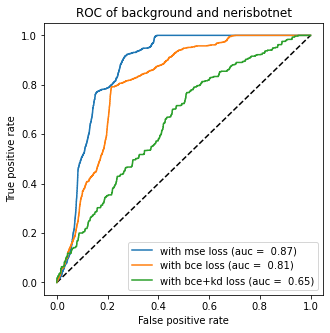

In [14]:
plot_roc(df, 'nerisbotnet')

### scan44

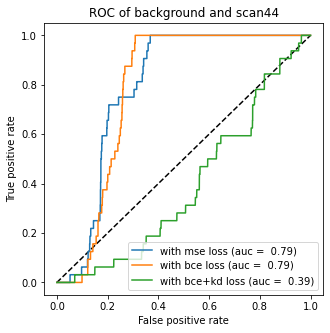

In [15]:
plot_roc(df, 'scan44')

### scan11

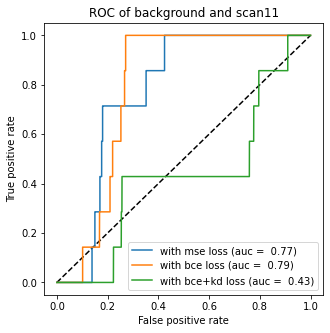

In [16]:
plot_roc(df, 'scan11')

## Plot Reconstruction Error Distribution

### anomaly-spam

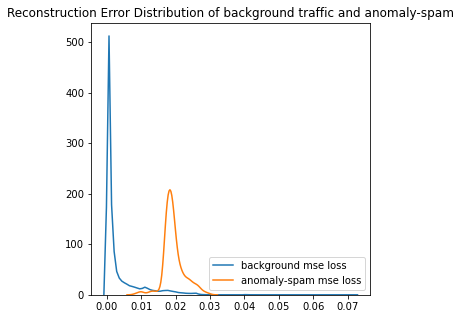

In [17]:
plot_kde(df, 'mse', 'anomaly-spam')

### blacklist

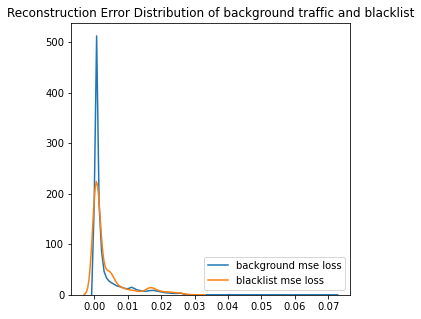

In [18]:
plot_kde(df, 'mse', 'blacklist')

### dos

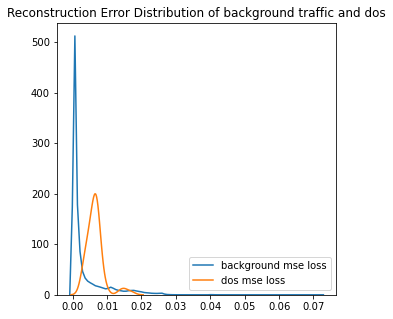

In [19]:
plot_kde(df, 'mse', 'dos')

### nerisbotnet

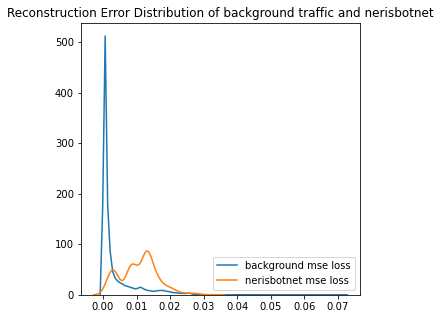

In [20]:
plot_kde(df, 'mse', 'nerisbotnet')

### scan44

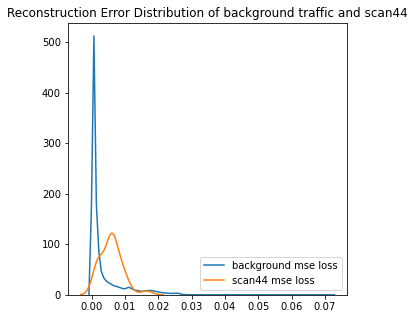

In [21]:
plot_kde(df, 'mse', 'scan44')

### scan11

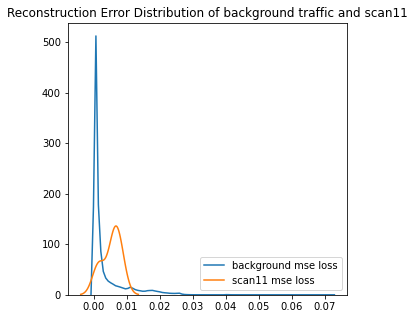

In [22]:
plot_kde(df, 'mse', 'scan11')

## Gradient Explainer

### anomaly-spam

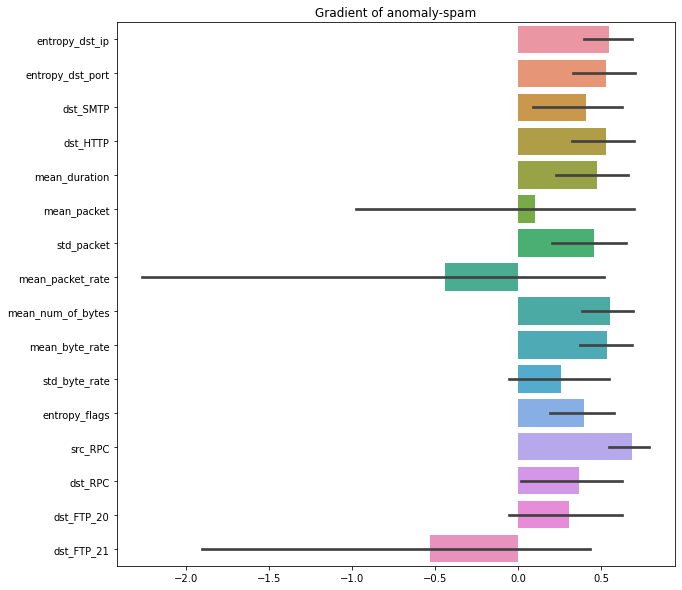

In [23]:
plot_gradient(df, 'anomaly-spam', model)

### blacklist

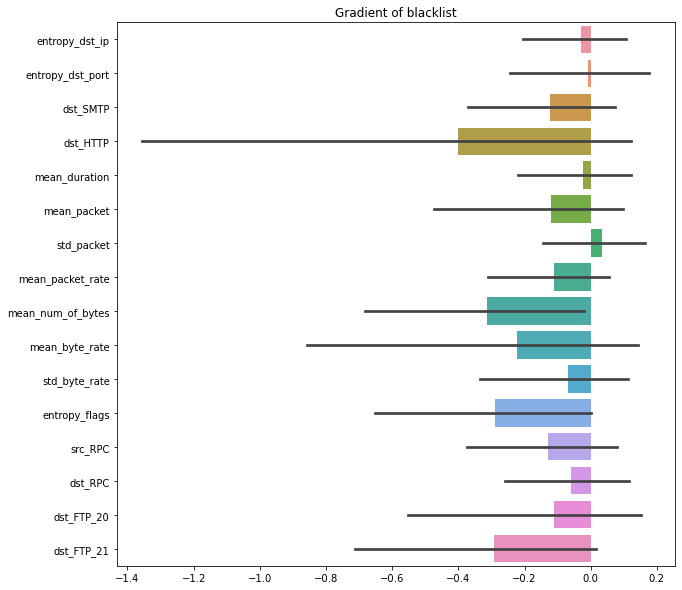

In [24]:
plot_gradient(df, 'blacklist', model)

### dos

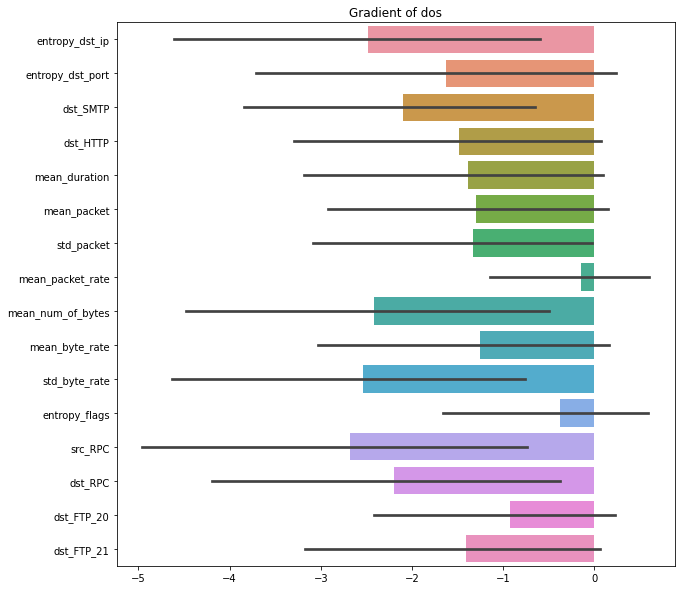

In [25]:
plot_gradient(df, 'dos', model)

### nerisbotnet

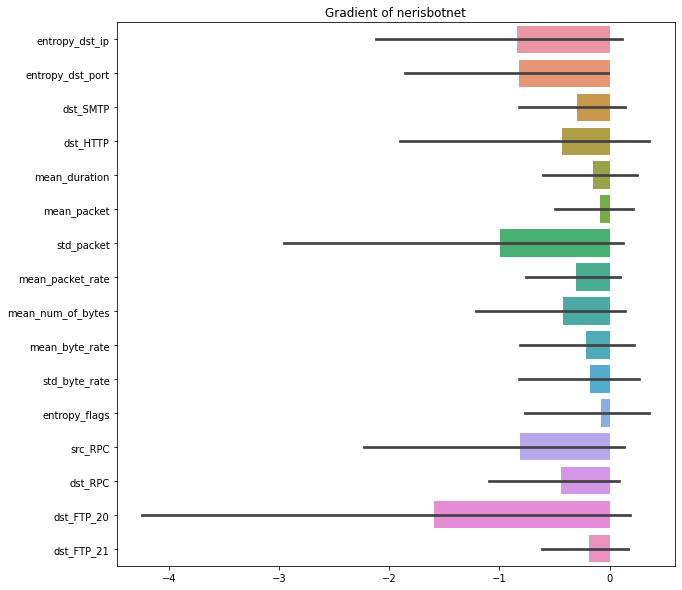

In [26]:
plot_gradient(df, 'nerisbotnet', model)

### scan44

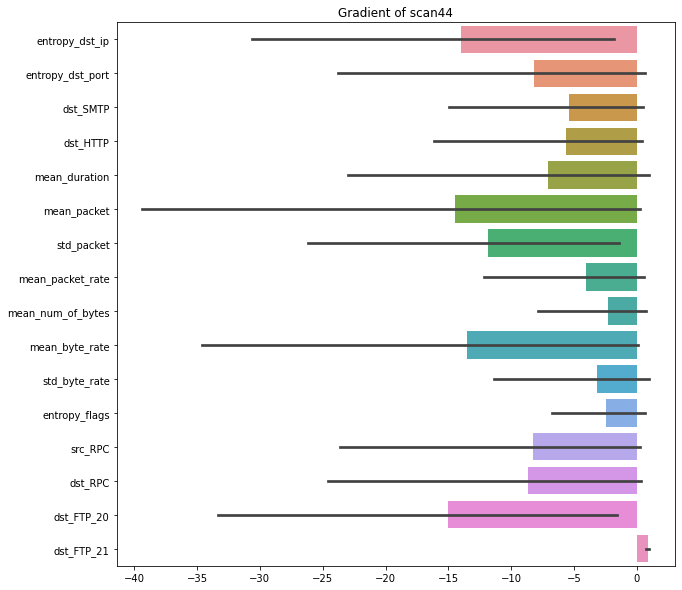

In [27]:
plot_gradient(df, 'scan44', model)

### scan11

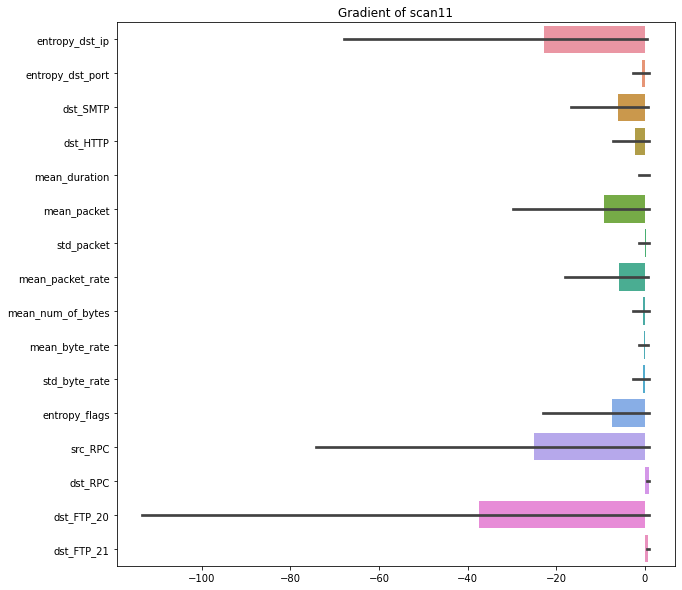

In [28]:
plot_gradient(df, 'scan11', model)